# Evaluating the Distribution of Forest Firefighting Crews in British Columbia as a Capacity Facilitated Location Problem 
#### Decision Analytics Final Project
**Jonah Walker**  
**Lau Jimenez**  
**Tala Abuzeid**  
**Alan Yang**  

### Import Libraries

In [284]:
# pip install geopandas

In [285]:
# Data manipulation
import pandas as pd
import numpy as np

# Handling Coordinates
import geopandas as gpd

# Gurobi
import gurobipy as gp
from gurobipy import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning - Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Machine Learning - Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Machine Learning - Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Statistical tests
from scipy import stats
import math

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Load and Clean Data
**Dataset:** [BC Wildfire Fire Incident Locations - Historical](https://catalogue.data.gov.bc.ca/dataset/bc-wildfire-fire-incident-locations-historical)  
Forest fire instances in British Columbia from 1950 to 2024. We are going to use data from fires that have occured since 2012. We are only going to use fires that actually drew a firefighting response (no fires that the government let burn for ecological reasons). There are fires that burned less than 0.1 hectares (and with NaN values) which we are going to remove.

Latitude and longitude is problematic for optimization because the physical distance of a "degree" shrinks as you move north. The X and Y coordinates used here are in 'BC Albers,' which is a projection of this curved surface onto a flat 2D plane measured in meters.

Features we will need for modeling:  
- X_COORDINATE
- Y_COORDINATE
- SIZE_HA
- IGN_DATE
- FR_T_DTE

Features we will need for cleaning and filtering:  
- FIRE_YEAR
- RSPNS_TYPC

In [286]:
df = pd.read_csv('H_FIRE_PNT.csv')
df = df[['FIRE_YEAR','RSPNS_TYPC','SIZE_HA','Y_COORDINATE','X_COORDINATE','IGN_DATE','FR_T_DTE']]
df.head()

,FIRE_YEAR,RSPNS_TYPC,SIZE_HA,Y_COORDINATE,X_COORDINATE,IGN_DATE,FR_T_DTE
0,2024,Full,0.009,7.901812e+05,1.374858e+06,2.024072e+13,2.024072e+13
1,2024,Full,1.700,1.006375e+06,9.614924e+05,2.024081e+13,2.024082e+13
2,2024,Full,1.400,4.503964e+05,1.115047e+06,2.024091e+13,2.024092e+13
3,2023,Modified,0.001,1.131540e+06,1.177946e+06,2.023092e+13,2.023092e+13
4,2024,Full,0.240,4.040671e+05,1.169573e+06,2.024063e+13,2.024070e+13


In [287]:
shape = df.shape
print(f'Total rows before removing NaN values: {shape[0]}')

number_of_nan_values = df.isna().sum()
print('NaN values:')
for column, count in number_of_nan_values.items():
  if count > 0:
    print(f"  - {column}: {count}")

Total rows before removing NaN values: 197557
NaN values:
  - RSPNS_TYPC: 154999
  - SIZE_HA: 15404
  - IGN_DATE: 18750
  - FR_T_DTE: 21501


#### Data Cleaning Steps
1. Remove data from before 2012
2. Full fire response only
3. No fires that didn't burn anything
4. Remove NaN values
5. Convert ignition date and fire out date to datetime features

#### Feature Engineering Steps
1. Create new feature DURATION_DAYS as the number of days it took the firefighters to put out the fire

In [288]:
df = df[
    (df['FIRE_YEAR'] >= 2012) & 
    (df['RSPNS_TYPC'] == 'Full') & 
    (df['SIZE_HA'] >= 0.1) & 
    df['SIZE_HA'].notna() &
    df['IGN_DATE'].notna() & 
    df['FR_T_DTE'].notna()
]

df['IGN_DATE'] = df['IGN_DATE'].astype('Int64').astype(str)
df['FR_T_DTE'] = df['FR_T_DTE'].astype('Int64').astype(str)
df['IGN_DATE'] = pd.to_datetime(df['IGN_DATE'], format='%Y%m%d%H%M%S', errors='coerce')
df['FR_T_DTE'] = pd.to_datetime(df['FR_T_DTE'], format='%Y%m%d%H%M%S', errors='coerce')

df['DURATION_DAYS'] = (df['FR_T_DTE'] - df['IGN_DATE']).dt.days

df = df[df['DURATION_DAYS'].notna()]

shape = df.shape
print(f'Total rows after cleaning: {shape[0]}')

df.dtypes

Total rows after cleaning: 8191


FIRE_YEAR                 int64
RSPNS_TYPC               object
SIZE_HA                 float64
Y_COORDINATE            float64
X_COORDINATE            float64
IGN_DATE         datetime64[ns]
FR_T_DTE         datetime64[ns]
DURATION_DAYS           float64
dtype: object

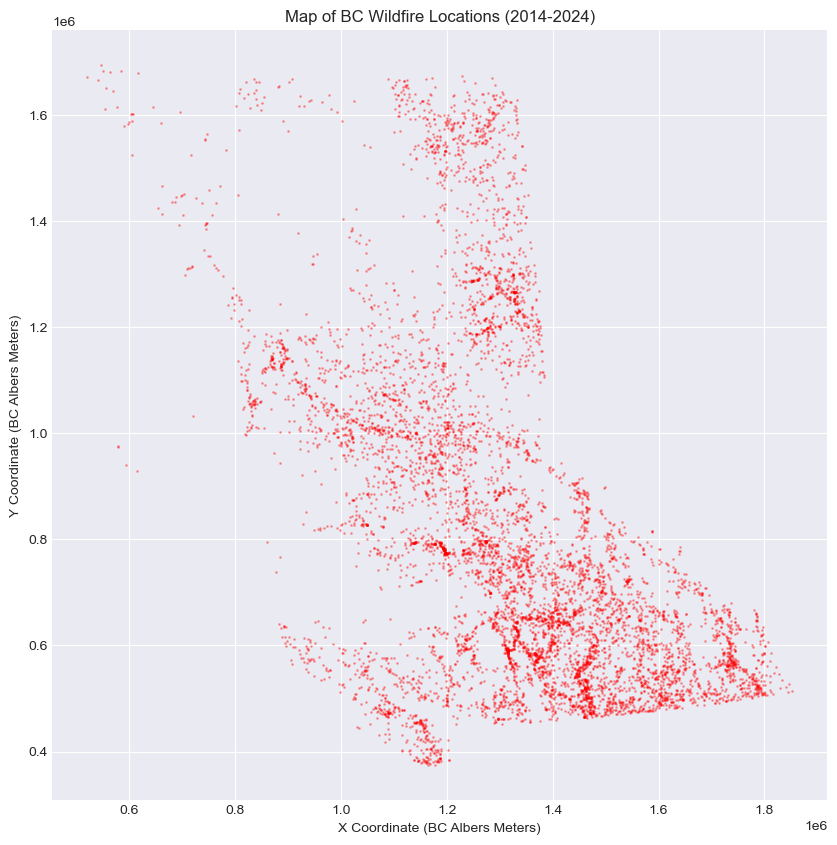

In [289]:
plt.figure(figsize=(10, 10))

plt.scatter(df['X_COORDINATE'], df['Y_COORDINATE'], s=1, c='red', alpha=0.3)

plt.title("Map of BC Wildfire Locations (2014-2024)")
plt.xlabel("X Coordinate (BC Albers Meters)")
plt.ylabel("Y Coordinate (BC Albers Meters)")
plt.axis('equal') 

plt.show()

### K-means clustering to determine fire zones
1. Prep X and Y coordinate as features (scale them down to km from m to save the model from having to use large numbers)
2. Prep damage in hectares as weights
3. Fit the model with n clusters
4. Get back n fire hotspots (and scale them up to m from km)

In [290]:
number_of_clusters = 25

In [291]:
X_features = df[['X_COORDINATE', 'Y_COORDINATE']].values / 1000 # convert m to km
weights = np.log1p(df['SIZE_HA'].values)

kmeans = KMeans(n_clusters = number_of_clusters, n_init = 'auto', random_state = 42)
kmeans.fit(X_features, sample_weight=weights)

KMeans(n_clusters=25, random_state=42)

In [292]:
# Get fire hotspots
fire_hotspots_plotting = kmeans.cluster_centers_ * 1000 # Converting back to m for the plot
fire_hotspots = kmeans.cluster_centers_ # For modeling in Gurobi, we are going to keep this as km

# Label each fire with its related fire hotspot
df['Cluster_ID'] = kmeans.labels_

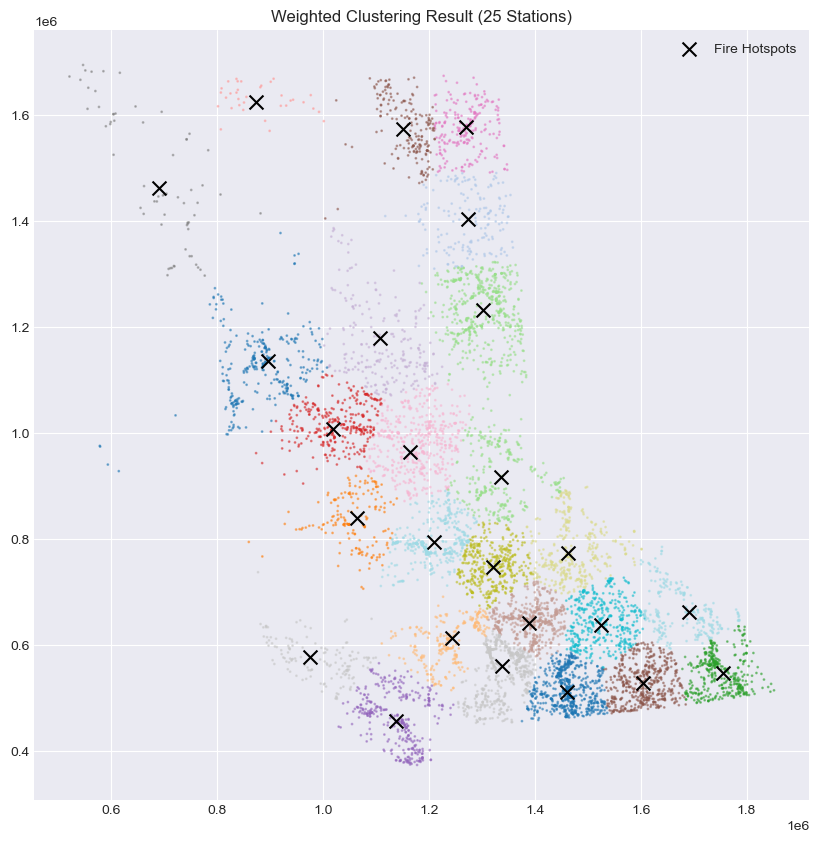

In [293]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot fires, coloured by its fire hotspot cluster
ax.scatter(df['X_COORDINATE'], df['Y_COORDINATE'], c=df['Cluster_ID'], s=1, cmap='tab20', alpha=0.5)

# Plot "The Fire Hotspot"
ax.scatter(fire_hotspots_plotting[:, 0], fire_hotspots_plotting[:, 1], c='black', s=100, marker='x', label='Fire Hotspots')

ax.set_title(f'Weighted Clustering Result ({number_of_clusters} Stations)')
ax.axis('equal')
plt.legend()
plt.show()

### Assigning each fire zone a "fire demand"  
In this model, we are going to define small fires as those that burn less than 4 hectares, and large fires as ones that burn more than 4 hectares. We are going to assume small fires take 2 days to put out, and large fires take 14 days to put out.

In [294]:
def get_fire_duration(size_ha):
    if size_ha < 1:
        return 0.5
    elif size_ha < 4:
        return 1
    elif size_ha <= 10:
        return 14
    else:
        return 14

In [295]:
# Apply above function to each fire in our dataframe
df['Estimated_Days'] = df['SIZE_HA'].apply(get_fire_duration)

In [296]:
zone_year = df.groupby(['Cluster_ID', 'FIRE_YEAR'], as_index=False)['Estimated_Days'].sum()

zones = np.arange(number_of_clusters)
years = np.arange(df['FIRE_YEAR'].min(), df['FIRE_YEAR'].max() + 1)

full = pd.MultiIndex.from_product([zones, years], names=['Cluster_ID', 'FIRE_YEAR']).to_frame(index=False)

zone_year_full = full.merge(zone_year, on=['Cluster_ID', 'FIRE_YEAR'], how='left')
zone_year_full['Estimated_Days'] = zone_year_full['Estimated_Days'].fillna(0)

df_avg_annual_dem = zone_year_full.groupby('Cluster_ID', as_index=False)['Estimated_Days'].agg(['mean']).reset_index()

In [297]:
df_avg_annual_dem.head()

,index,Cluster_ID,mean
0,0,0,78.692308
1,1,1,176.884615
2,2,2,86.192308
3,3,3,72.307692
4,4,4,71.038462


### Prepare existing fire station data
Here we convert latitude and longitude coordinates of exsisting forest firefighting stations to BC Albers. Pipeline takes an array of dictionaries, converts to a GeoDataFrame, does the reprojection, and outputs a gurobi-ready dictionary with the locations of all the stations on it.

In [298]:
raw_data = [
    {"Name": "Hazelton", "Lat": 55.256817, "Long": -127.672002},
    {"Name": "Telkwa", "Lat": 54.694500, "Long": -127.047500},
    {"Name": "Terrace", "Lat": 54.518193, "Long": -128.603154},
    {"Name": "Burns Lake", "Lat": 54.229720, "Long": -125.760840},
    {"Name": "Fort St. John", "Lat": 56.246464, "Long": -120.847633},
    {"Name": "Mackenzie", "Lat": 55.338056, "Long": -123.094444},
    {"Name": "Vanderhoof", "Lat": 54.017450, "Long": -124.010350},
    {"Name": "Prince George", "Lat": 53.917280, "Long": -122.747500},
    {"Name": "Valemount", "Lat": 52.831220, "Long": -119.264311},
    {"Name": "Revelstoke", "Lat": 50.998115, "Long": -118.195672},
    {"Name": "Cranbrook", "Lat": 49.509724, "Long": -115.766670},
    {"Name": "Grand Forks", "Lat": 49.033333, "Long": -118.440002},
    {"Name": "Shoreacres", "Lat": 49.433333, "Long": -117.533333},
    {"Name": "Quesnel", "Lat": 52.9784, "Long": -122.4931},
    {"Name": "Alexis Creek", "Lat": 52.0833, "Long": -123.2830},
    {"Name": "Williams Lake", "Lat": 52.1417, "Long": -122.1444},
    {"Name": "100 Mile House", "Lat": 51.6498, "Long": -121.2859},
    {"Name": "Bella Coola", "Lat": 52.3667, "Long": -126.7539},
    {"Name": "Campbell River", "Lat": 50.0244, "Long": -125.2470},
    {"Name": "Sunshine Coast", "Lat": 49.4769, "Long": -123.7590},
    {"Name": "Errington", "Lat": 49.2990, "Long": -124.3804},
    {"Name": "Port Alberni", "Lat": 49.2339, "Long": -124.8050},
    {"Name": "Cobble Hill", "Lat": 48.6527, "Long": -123.5922},
    {"Name": "Squamish", "Lat": 49.7016, "Long": -123.1558},
    {"Name": "Cultus Lake", "Lat": 49.0557, "Long": -122.0143},
    {"Name": "Hope", "Lat": 49.3825, "Long": -121.4410},
    {"Name": "Pemberton", "Lat": 50.3200, "Long": -122.8050},
    {"Name": "Lillooet", "Lat": 50.6840, "Long": -121.9370},
    {"Name": "Lytton", "Lat": 50.2347, "Long": -121.5750},
    {"Name": "Merritt", "Lat": 50.1123, "Long": -120.7897},
    {"Name": "Princeton", "Lat": 49.4580, "Long": -120.5070},
    {"Name": "Kamloops", "Lat": 50.7053, "Long": -120.4418},
    {"Name": "Salmon Arm", "Lat": 50.6878, "Long": -119.2367}
]

# Convert to dataframe, then a GeoDataFrame
df_stations = pd.DataFrame(raw_data)
gdf_stations = gpd.GeoDataFrame(
    df_stations, 
    geometry=gpd.points_from_xy(df_stations.Long, df_stations.Lat),
    crs="EPSG:4326"
)

# Reprojection
gdf_stations = gdf_stations.to_crs("EPSG:3005")

gdf_stations['X_km'] = gdf_stations.geometry.x / 1000.0
gdf_stations['Y_km'] = gdf_stations.geometry.y / 1000.0

# Create a Gurobi-ready dictionary where Key = Name, Value = (X, Y) in KM
stations_dict = gdf_stations.set_index('Name')[['X_km', 'Y_km']].T.to_dict('list')
stations = {k: tuple(v) for k, v in stations_dict.items()}

# Prepare Gurobi

In [299]:
m = Model("BC Forest Fire Crew Optimization")
m.Params.LogToConsole = 0

Set parameter LogToConsole to value 0


In [300]:
# I: Set of fire stations
I = list(range(len(stations)))

# Save names for printing later
station_names = list(stations.keys())

# K: Set of crew types
K = ['IA', 'Rapattack', 'Parattack', 'Unit'] 

# W: For each cluster, estimated number of days required to put out all the fires. 
W = df_avg_annual_dem.set_index('Cluster_ID')['mean'].to_dict()

# J: Set of fire demand zones (clusters)
J = list(W.keys())

# Days per season a crew could operate
Cap = {
    'IA': 219,
    'Rapattack': 219,
    'Parattack': 219,
    'Unit': 219
}

v = {
    'Unit': 110,       # ground crews slowest (trucks/hiking)
    'IA': 200,         # helicopter IA crew
    'Rapattack': 200,  # helicopter rapattack
    'Parattack': 350   # plane-based Parattack crews fastest
}

max_crews = {
    'Parattack': 15,
    'IA': 100,
    'Unit': 30,
    'Rapattack': 10
} 


In [301]:
# Nested dictionary for distances: D[station][zone] = distance
D = {}

# Convert station names to a simple index (i) while keeping names available if needed
station_names = list(stations.keys())

for i, station_name in enumerate(station_names):
    x1, y1 = stations[station_name]
    
    # Create inner dictionary for distances from station i to all hotspots j
    D[i] = {}
    
    for j in range(len(fire_hotspots)):
        x2, y2 = fire_hotspots[j]
        
        # Euclidean distance
        dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        
        # Store in nested dictionary
        D[i][j] = dist

In [302]:
# Variable Y_ik: Integer variable representing the number of crews of type k stationed at location i.
Y = m.addVars(I, K, vtype=GRB.INTEGER, lb=0, name="Y_CrewsStationed")

# Variable X_ijk: Continuous variable representing the fraction of demand in zone j serviced by crew k from station i.
X = m.addVars(I, J, K, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="X_ServiceFraction")

# (7) At most 2 stations may host Rapattack crews
Z_rap = m.addVars(I, vtype=GRB.BINARY, name="Z_RapattackHost")

# (6) At most 2 stations may host Parattack crews
Z_par = m.addVars(I, vtype=GRB.BINARY, name="Z_ParattackHost")

# Create binary variables to detect whether a station hosts aircrews
Z_air_par = m.addVars(I, vtype=GRB.BINARY, name="Z_ParattackPresence")
Z_air_rap = m.addVars(I, vtype=GRB.BINARY, name="Z_RapattackPresence")


In [303]:
# Objective: Minimize total weighted response distance
m.setObjective(
    gp.quicksum( (D[i][j] / v[k]) * W[j] * X[i,j,k]
                 for i in I 
                 for j in J 
                 for k in K),
    GRB.MINIMIZE
)

In [304]:
# (1) Every fire zone j must be 100% served
for j in J:
    m.addConstr(
        gp.quicksum(X[i,j,k] for i in I for k in K) == 1,
        name=f"DemandSatisfaction_{j}"
    )

# (2) Station capacity for each crew type
for i in I:
    for k in K:
        m.addConstr(
            gp.quicksum(W[j] * X[i,j,k] for j in J) <= Cap[k] * Y[i,k],
            name=f"Capacity_{i}_{k}"
        )

# (3) Total crews of each type cannot exceed real BC Wildfire staffing
# Sum of Y[i,k] across all stations <= allowed amount
for k in K: 
    m.addConstr(
        gp.quicksum(Y[i,k] for i in I) <= max_crews[k],
        name=f"MaxCrews_{k}"
    )

# (4) IA requirement: If a station has ANY aircrew, it must have ≥ 1 IA crew

# Linking: If Y[i,'Parattack'] ≥ 1 then Z_air_par[i] = 1
for i in I:
    m.addConstr(
        Y[i, 'Parattack'] <= 1000 * Z_air_par[i],
        name=f"Link_ParattackPresence_{i}"
    )

# Linking: If Y[i,'Rapattack'] ≥ 1 then Z_air_rap[i] = 1
for i in I:
    m.addConstr(
        Y[i, 'Rapattack'] <= 1000 * Z_air_rap[i],
        name=f"Link_RapattackPresence_{i}"
    )

# IA requirement: If ANY aircrew present, IA must be ≥ 1
for i in I:
    m.addConstr(
        Y[i, 'IA'] >= Z_air_par[i] + Z_air_rap[i],
        name=f"IA_required_if_any_aircrew_station_{i}"
    )

# (5) No more than 2 Unit crews, and 20 IA crews per station
for i in I:
    m.addConstr(
        Y[i, 'Unit'] <= 2,
        name=f"MaxUnitCrews_PerStation_{i}"
    )

for i in I:
    m.addConstr(
        Y[i, 'IA'] <= 15,
        name=f"MaxUnitCrews_PerStation_{i}"
    )

# (6) At most 2 stations may host Parattack crews

# Linking constraints: if Y[i,'Parattack'] >= 1 → Z_par[i] = 1
for i in I:
    m.addConstr(
        Y[i, 'Parattack'] <= 1000 * Z_par[i],   # if Z=0 → forces Y=0
        name=f"Link_ParattackHost_{i}"
    )

# Sum of host stations ≤ 2
m.addConstr(
    gp.quicksum(Z_par[i] for i in I) <= 2,
    name="Max_Parattack_HostStations"
)

# (7) At most 2 stations may host Rapattack crews

# Linking constraints: if Y[i,'Rapattack'] >= 1 → Z_rap[i] = 1
for i in I:
    m.addConstr(
        Y[i, 'Rapattack'] <= 1000 * Z_rap[i],   # if Z=0 → forces Y=0
        name=f"Link_RapattackHost_{i}"
    )

# Sum of host stations ≤ 2
m.addConstr(
    gp.quicksum(Z_rap[i] for i in I) <= 2,
    name="Max_Rapattack_HostStations"
)

# Have all crews 

for k in K:
    m.addConstr(
        gp.quicksum(Y[i,k] for i in I) == max_crews[k],
        name=f"MustUseAllCrews_{k}"
    )

In [305]:
print(W)

{0: 78.6923076923077, 1: 176.8846153846154, 2: 86.1923076923077, 3: 72.3076923076923, 4: 71.03846153846153, 5: 95.26923076923077, 6: 215.3846153846154, 7: 86.88461538461539, 8: 108.38461538461539, 9: 15.153846153846153, 10: 58.57692307692308, 11: 89.96153846153847, 12: 60.76923076923077, 13: 98.65384615384616, 14: 158.8846153846154, 15: 92.96153846153847, 16: 145.92307692307693, 17: 23.576923076923077, 18: 36.11538461538461, 19: 162.0, 20: 116.15384615384616, 21: 78.03846153846153, 22: 91.88461538461539, 23: 171.15384615384616, 24: 60.88461538461539}


In [306]:
# Crew-Type Eligibility Constraint

# Maximum response distance allowed (km) for each crew type
MaxDist = {
    'IA': 500,
    'Rapattack': 700,   
    'Parattack': 800,   
    'Unit': 500        
}

for i in I:
    for j in J:
        for k in K:
            if D[i][j] > MaxDist[k]:
                m.addConstr(X[i,j,k] == 0, 
                            name=f"MaxDist_{i}_{j}_{k}")
                
# IA Must Serve Before Any Advanced Crew Can Serve a Zone
for j in J:
    for k in ['Unit','Rapattack','Parattack']:
        m.addConstr(
            gp.quicksum(X[i,j,'IA'] for i in I) >= 
            gp.quicksum(X[i,j,k] for i in I),
            name=f"IA_precedes_{k}_zone_{j}"
        )

# Minimum IA Contribution
min_IA_share = 0.50   # adjust as needed

for j in J:
    m.addConstr(
        gp.quicksum(X[i,j,'IA'] for i in I) >= min_IA_share,
        name=f"IA_min_share_zone_{j}"
    )



In [307]:
# =============================================
# Realistic workload sharing rules:
# IA/Parattack capped only for large fire zones
# =============================================

# Threshold for large zones (crew-days)
T_large = 150  # adjustable

for j in J:

    if W[j] >= T_large:   # Large fire zone
        # Caps on IA and Parattack (per-station)
        for i in I:
            m.addConstr(X[i,j,'IA'] <= 0.6,
                        name=f"IA_cap_large_{i}_{j}")
            m.addConstr(X[i,j,'Parattack'] <= 0.4,
                        name=f"Par_cap_large_{i}_{j}")

        # Minimum total Unit workload (zone-level)
        m.addConstr(
            gp.quicksum(X[i,j,'Unit'] for i in I) >= 0.20,
            name=f"Unit_min_large_{j}"
        )

        # Minimum total Rapattack workload (zone-level)
        m.addConstr(
            gp.quicksum(X[i,j,'Rapattack'] for i in I) >= 0.10,
            name=f"Rap_min_large_{j}"
        )

    else:
        pass  # small fires: IA can go up to 100%, no lower bounds



In [308]:
#m.computeIIS()
#m.write("infeasible.ilp")

#with open("infeasible.ilp", "r") as f:
#    txt = f.read()

#print(txt[:5000])  # print first 5000 characters so it doesn't explode


In [309]:
# Optimize the model
m.optimize()

In [310]:
for j in J:
    feasible = False
    for k in K:
        # Is there at least one station i where this crew type k can reach j?
        if any(D[i][j] <= MaxDist[k] for i in I):
            feasible = True
    if not feasible:
        print(f"⚠️ Zone {j} is unreachable by ALL crew types under MaxDist.")


In [311]:
print("\nMODEL STATUS:", m.Status)


MODEL STATUS: 2


In [312]:
print("\n==============================")
print(" Objective Function Value")
print("==============================")
print(f"Minimum Total Response Cost = {m.objVal:,.4f}\n")


 Objective Function Value
Minimum Total Response Cost = 834.0317



In [313]:
print("\n==============================")
print(" Decision Variables: Y[i,k] (Crews Assigned)")
print("==============================\n")

for i in I:
    for k in K:
        print(f"Y[{station_names[i]}, {k}] = {Y[i,k].X}")


 Decision Variables: Y[i,k] (Crews Assigned)

Y[Hazelton, IA] = 15.0
Y[Hazelton, Rapattack] = -0.0
Y[Hazelton, Parattack] = -0.0
Y[Hazelton, Unit] = 2.0
Y[Telkwa, IA] = 1.0
Y[Telkwa, Rapattack] = -0.0
Y[Telkwa, Parattack] = 0.0
Y[Telkwa, Unit] = 2.0
Y[Terrace, IA] = 1.0
Y[Terrace, Rapattack] = -0.0
Y[Terrace, Parattack] = 0.0
Y[Terrace, Unit] = 2.0
Y[Burns Lake, IA] = 1.0
Y[Burns Lake, Rapattack] = -0.0
Y[Burns Lake, Parattack] = 0.0
Y[Burns Lake, Unit] = 2.0
Y[Fort St. John, IA] = 2.0
Y[Fort St. John, Rapattack] = 9.0
Y[Fort St. John, Parattack] = 14.0
Y[Fort St. John, Unit] = 2.0
Y[Mackenzie, IA] = 1.0
Y[Mackenzie, Rapattack] = -0.0
Y[Mackenzie, Parattack] = 0.0
Y[Mackenzie, Unit] = 2.0
Y[Vanderhoof, IA] = 1.0
Y[Vanderhoof, Rapattack] = -0.0
Y[Vanderhoof, Parattack] = 0.0
Y[Vanderhoof, Unit] = 2.0
Y[Prince George, IA] = -0.0
Y[Prince George, Rapattack] = -0.0
Y[Prince George, Parattack] = 0.0
Y[Prince George, Unit] = 2.0
Y[Valemount, IA] = -0.0
Y[Valemount, Rapattack] = -0.0
Y[Valem

In [314]:
print("\n==============================")
print(" Decision Variables: X[i,j,k] (Service Fractions)")
print("==============================\n")

for i in I:
    for j in J:
        for k in K:
            if X[i,j,k].X > 1e-6:
                print(f"X[{station_names[i]}, Zone {j}, {k}] = {X[i,j,k].X:.4f}")


 Decision Variables: X[i,j,k] (Service Fractions)

X[Hazelton, Zone 0, IA] = 1.0000
X[Hazelton, Zone 9, IA] = 0.5000
X[Hazelton, Zone 17, IA] = 0.5000
X[Burns Lake, Zone 8, IA] = 1.0000
X[Fort St. John, Zone 2, IA] = 0.5000
X[Fort St. John, Zone 2, Parattack] = 0.5000
X[Fort St. John, Zone 6, IA] = 0.5000
X[Fort St. John, Zone 6, Rapattack] = 0.1000
X[Fort St. John, Zone 6, Parattack] = 0.2000
X[Fort St. John, Zone 6, Unit] = 0.2000
X[Fort St. John, Zone 9, Parattack] = 0.5000
X[Fort St. John, Zone 12, IA] = 0.5000
X[Fort St. John, Zone 12, Parattack] = 0.5000
X[Fort St. John, Zone 15, IA] = 0.5000
X[Fort St. John, Zone 15, Parattack] = 0.5000
X[Fort St. John, Zone 17, Parattack] = 0.5000
X[Mackenzie, Zone 11, IA] = 1.0000
X[Vanderhoof, Zone 16, IA] = 1.0000
X[Revelstoke, Zone 21, IA] = 0.5000
X[Revelstoke, Zone 21, Parattack] = 0.5000
X[Revelstoke, Zone 22, Parattack] = 0.5000
X[Revelstoke, Zone 24, Parattack] = 0.5000
X[Cranbrook, Zone 5, IA] = 1.0000
X[Cranbrook, Zone 24, IA] = 0.5

In [315]:

print("\n==============================")
print(" Binary Decision Variables")
print("==============================\n")

print("Parattack Presence (Z_air_par):")
for i in I:
    print(f"  {station_names[i]}: {Z_air_par[i].X}")

print("\nRapattack Presence (Z_air_rap):")
for i in I:
    print(f"  {station_names[i]}: {Z_air_rap[i].X}")

print("\nParattack Host Bases (Z_par):")
for i in I:
    print(f"  {station_names[i]}: {Z_par[i].X}")

print("\nRapattack Host Bases (Z_rap):")
for i in I:
    print(f"  {station_names[i]}: {Z_rap[i].X}")



 Binary Decision Variables

Parattack Presence (Z_air_par):
  Hazelton: 1.0
  Telkwa: 1.0
  Terrace: 1.0
  Burns Lake: 1.0
  Fort St. John: 1.0
  Mackenzie: 1.0
  Vanderhoof: 1.0
  Prince George: 0.0
  Valemount: 0.0
  Revelstoke: 1.0
  Cranbrook: 1.0
  Grand Forks: -0.0
  Shoreacres: 1.0
  Quesnel: 1.0
  Alexis Creek: -0.0
  Williams Lake: 0.0
  100 Mile House: 1.0
  Bella Coola: 1.0
  Campbell River: -0.0
  Sunshine Coast: 0.0
  Errington: -0.0
  Port Alberni: -0.0
  Cobble Hill: -0.0
  Squamish: -0.0
  Cultus Lake: -0.0
  Hope: 0.0
  Pemberton: -0.0
  Lillooet: -0.0
  Lytton: 0.0
  Merritt: -0.0
  Princeton: 0.0
  Kamloops: 0.0
  Salmon Arm: 1.0

Rapattack Presence (Z_air_rap):
  Hazelton: 0.0
  Telkwa: -0.0
  Terrace: -0.0
  Burns Lake: 0.0
  Fort St. John: 1.0
  Mackenzie: 0.0
  Vanderhoof: -0.0
  Prince George: -0.0
  Valemount: -0.0
  Revelstoke: -0.0
  Cranbrook: -0.0
  Grand Forks: 0.0
  Shoreacres: 0.0
  Quesnel: 0.0
  Alexis Creek: 1.0
  Williams Lake: 0.0
  100 Mile House:

In [316]:
# ---------------------------------------------------------
# Nicely formatted output: Where crews are stationed
# ---------------------------------------------------------

print("\n" + "="*70)
print("               OPTIMAL CREW STATIONING RESULTS")
print("="*70 + "\n")

station_names = list(stations.keys())   # to recover actual names

for i in I:
    # Extract all assigned crews at this station (only non-zero)
    assigned_crews = [(k, Y[i,k].X) for k in K if Y[i,k].X > 0.0001]
    
    if len(assigned_crews) == 0:
        continue  # skip stations with no crews assigned
    
    print(f"Station: {station_names[i]}")
    print("-" * (10 + len(station_names[i])))
    
    total_crews_here = 0
    
    for k, val in assigned_crews:
        crew_count = int(round(val))
        total_crews_here += crew_count
        print(f"   • {k} Crews: {crew_count}")
    
    print(f"   → Total Crews at this Station: {total_crews_here}\n")

print("="*70)
print("                END OF CREW ASSIGNMENT REPORT")
print("="*70 + "\n")



               OPTIMAL CREW STATIONING RESULTS

Station: Hazelton
------------------
   • IA Crews: 15
   • Unit Crews: 2
   → Total Crews at this Station: 17

Station: Telkwa
----------------
   • IA Crews: 1
   • Unit Crews: 2
   → Total Crews at this Station: 3

Station: Terrace
-----------------
   • IA Crews: 1
   • Unit Crews: 2
   → Total Crews at this Station: 3

Station: Burns Lake
--------------------
   • IA Crews: 1
   • Unit Crews: 2
   → Total Crews at this Station: 3

Station: Fort St. John
-----------------------
   • IA Crews: 2
   • Rapattack Crews: 9
   • Parattack Crews: 14
   • Unit Crews: 2
   → Total Crews at this Station: 27

Station: Mackenzie
-------------------
   • IA Crews: 1
   • Unit Crews: 2
   → Total Crews at this Station: 3

Station: Vanderhoof
--------------------
   • IA Crews: 1
   • Unit Crews: 2
   → Total Crews at this Station: 3

Station: Prince George
-----------------------
   • Unit Crews: 2
   → Total Crews at this Station: 2

Station: Val

In [317]:
print("Total number of constraints:", m.numConstrs)


Total number of constraints: 1875


In [318]:
for c in m.getConstrs():
    print(c.ConstrName)


DemandSatisfaction_0
DemandSatisfaction_1
DemandSatisfaction_2
DemandSatisfaction_3
DemandSatisfaction_4
DemandSatisfaction_5
DemandSatisfaction_6
DemandSatisfaction_7
DemandSatisfaction_8
DemandSatisfaction_9
DemandSatisfaction_10
DemandSatisfaction_11
DemandSatisfaction_12
DemandSatisfaction_13
DemandSatisfaction_14
DemandSatisfaction_15
DemandSatisfaction_16
DemandSatisfaction_17
DemandSatisfaction_18
DemandSatisfaction_19
DemandSatisfaction_20
DemandSatisfaction_21
DemandSatisfaction_22
DemandSatisfaction_23
DemandSatisfaction_24
Capacity_0_IA
Capacity_0_Rapattack
Capacity_0_Parattack
Capacity_0_Unit
Capacity_1_IA
Capacity_1_Rapattack
Capacity_1_Parattack
Capacity_1_Unit
Capacity_2_IA
Capacity_2_Rapattack
Capacity_2_Parattack
Capacity_2_Unit
Capacity_3_IA
Capacity_3_Rapattack
Capacity_3_Parattack
Capacity_3_Unit
Capacity_4_IA
Capacity_4_Rapattack
Capacity_4_Parattack
Capacity_4_Unit
Capacity_5_IA
Capacity_5_Rapattack
Capacity_5_Parattack
Capacity_5_Unit
Capacity_6_IA
Capacity_6_Rap

In [319]:
# ============================================================
#   COUNT CONSTRAINTS IN THE MODEL BY CATEGORY
# ============================================================

constrs = m.getConstrs()

def count(prefix):
    return sum(c.ConstrName.startswith(prefix) for c in constrs)

print("\n==============================")
print(" CONSTRAINT COUNT SUMMARY")
print("==============================")

print(f"Demand satisfaction constraints:         {count('DemandSatisfaction_')}")
print(f"Capacity constraints:                    {count('Capacity_')}")
print(f"Max crews constraints:                   {count('MaxCrews_')}")
print(f"Must use all crews constraints:          {count('MustUseAllCrews_')}")
print(f"IA required if aircrew present:          {count('IA_required_if_any_aircrew_station_')}")
print(f"Link Parattack presence constraints:     {count('Link_ParattackPresence_')}")
print(f"Link Rapattack presence constraints:     {count('Link_RapattackPresence_')}")
print(f"Max Unit per station constraints:        {count('MaxUnitCrews_PerStation_')}")
print(f"Max IA per station constraints:          {count('MaxUnitCrews_PerStation_') - count('MaxUnitCrews_PerStation_')}")  # optional fix
print(f"Parattack host linking constraints:      {count('Link_ParattackHost_')}")
print(f"Rapattack host linking constraints:      {count('Link_RapattackHost_')}")
print(f"Max Parattack host stations constraint:  {count('Max_Parattack_HostStations')}")
print(f"Max Rapattack host stations constraint:  {count('Max_Rapattack_HostStations')}")

print(f"Max distance constraints:                {count('MaxDist_')}")
print(f"IA precedence constraints:               {count('IA_precedes_')}")
print(f"IA minimum share constraints:            {count('IA_min_share_zone_')}")

print(f"IA cap for large zones constraints:      {count('IA_cap_large_')}")
print(f"Parattack cap for large zones:           {count('Par_cap_large_')}")
print(f"Unit minimum share for large zones:      {count('Unit_min_large_')}")
print(f"Rapattack minimum share for large zones: {count('Rap_min_large_')}")

print("\n------------------------------")
print(f"TOTAL constraints reported: {m.numConstrs}")
print("------------------------------\n")



 CONSTRAINT COUNT SUMMARY
Demand satisfaction constraints:         25
Capacity constraints:                    132
Max crews constraints:                   4
Must use all crews constraints:          4
IA required if aircrew present:          33
Link Parattack presence constraints:     33
Link Rapattack presence constraints:     33
Max Unit per station constraints:        66
Max IA per station constraints:          0
Parattack host linking constraints:      33
Rapattack host linking constraints:      33
Max Parattack host stations constraint:  1
Max Rapattack host stations constraint:  1
Max distance constraints:                1037
IA precedence constraints:               75
IA minimum share constraints:            25
IA cap for large zones constraints:      165
Parattack cap for large zones:           165
Unit minimum share for large zones:      5
Rapattack minimum share for large zones: 5

------------------------------
TOTAL constraints reported: 1875
------------------------------

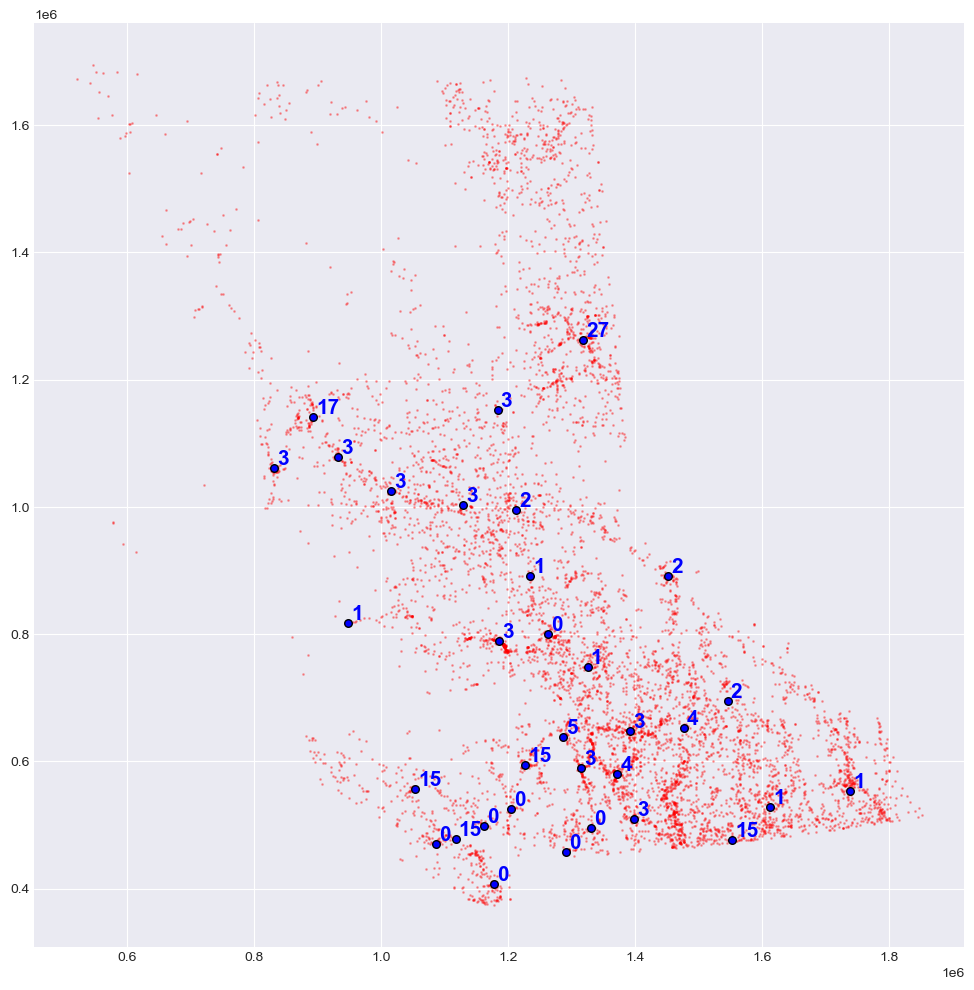

In [320]:
plt.figure(figsize=(12, 12))

# ------------------------------------------------------
# Plot 1: Wildfires (already in meters)
# ------------------------------------------------------
plt.scatter(
    df['X_COORDINATE'],
    df['Y_COORDINATE'],
    s=1,
    c='red',
    alpha=0.3,
    label='Wildfires (2014–2024)'
)

# ------------------------------------------------------
# Convert station coords from km → meters
# ------------------------------------------------------
station_x = []
station_y = []
station_labels = list(stations.keys())

for name in station_labels:
    x_km, y_km = stations[name]
    station_x.append(x_km * 1000)  # convert to meters
    station_y.append(y_km * 1000)  # convert to meters

# ------------------------------------------------------
# Compute total crews from optimized Y
# ------------------------------------------------------
station_total_crews = []
for i in I:
    total = sum(Y[i, k].X for k in K)
    station_total_crews.append(total)

# ------------------------------------------------------
# Plot station points
# ------------------------------------------------------
plt.scatter(
    station_x,
    station_y,
    c='blue',
    s=30,
    edgecolors='black',
    label='Fire Stations'
)

# ------------------------------------------------------
# Add station crew counts as text labels
# ------------------------------------------------------
for i, name in enumerate(station_labels):
    crew_count = station_total_crews[i]
    plt.text(
        station_x[i] + 5000,     # slight offset so text does not overlap marker
        station_y[i] + 5000,
        str(int(crew_count)),    # convert to int
        fontsize=15,
        color='blue',
        weight='bold'
    )

# ------------------------------------------------------
# Formatting
# ------------------------------------------------------
plt.axis('equal')

plt.show()